In [10]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# 📥 Load dataset
df = pd.read_csv("/kaggle/input/anomaly/anomaly_detection (1).csv")
df["timestamp"] = pd.to_datetime(df["timestamp"])
df = df.sort_values("timestamp").dropna().reset_index(drop=True)


# # Filter realistic pH values (industry acceptable range)
df = df[(df["pH"] >= 5.5) & (df["pH"] <= 9.0)]

# Smooth target
df["pH_smooth"] = df["pH"].rolling(window=3).mean()


# ⚙️ Engineered features
df["ph_diff"] = df["pH"].diff()
df["pH_rollmean_3"] = df["pH"].rolling(window=3).mean()
df["pH_rollstd_3"] = df["pH"].rolling(window=3).std()
df["tds_x_temp"] = df["TDS"] * df["temperature"]
df["turb_over_tds"] = df["turbidity"] / (df["TDS"] + 1)
df["ph_x_temp"] = df["pH"] * df["temperature"]
df["tds_temp_ph_ratio"] = df["TDS"] / ((df["temperature"] * df["pH"]) + 1)
df = df.dropna().reset_index(drop=True)



In [11]:
# 🎯 Features for upgraded model
features_ph = [
    "TDS", "turbidity", "temperature",
    "tds_temp_ratio", "turbidity_x_ph", "temp_sqr",
    "tds_diff", "temp_diff", "ph_diff", "pH_rollmean_3", "pH_rollstd_3",
    "tds_x_temp", "turb_over_tds", "ph_x_temp", "tds_temp_ph_ratio"
]

X = df[features_ph]
y = df["pH_smooth"]
# Train pro-level XGBoost model
model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.03,
    max_depth=5,
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)




In [15]:
# 🔀 Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# 🚀 Train XGBoost model
model_ph = XGBRegressor(n_estimators=200, learning_rate=0.05, random_state=42)
model_ph.fit(X_train, y_train)

# 📊 Predictions and metrics
y_pred = model_ph.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.5f}")


MAE: 0.0016
RMSE: 0.0089
R² Score: 0.99813


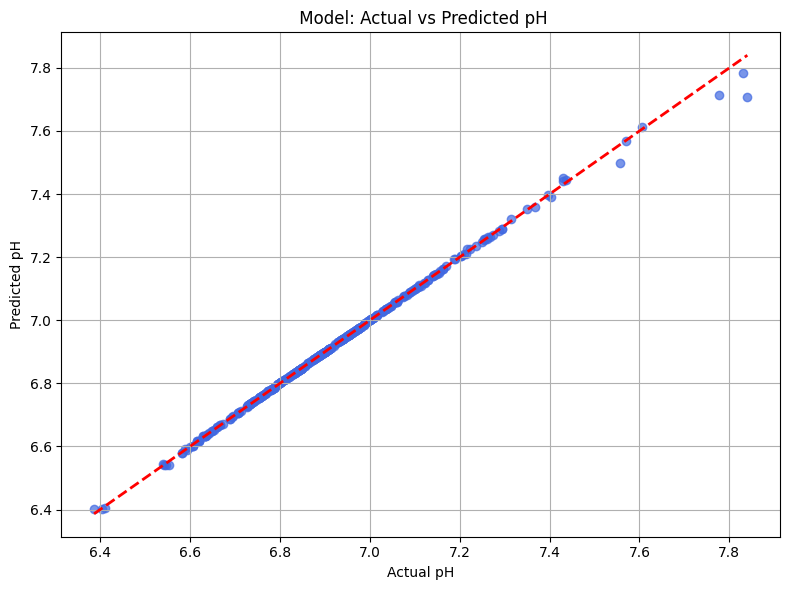

In [16]:
# 📈 Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7, color='royalblue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual pH")
plt.ylabel("Predicted pH")
plt.title(" Model: Actual vs Predicted pH")
plt.grid(True)
plt.tight_layout()
plt.show()

In [17]:
# 💾 Save model
import joblib
joblib.dump(model_ph, "ph_forecast_model.pkl")

['ph_forecast_model.pkl']

/tmp/ipykernel_36/1603689231.py:18: UserWarning: Glyph 127775 (\N{GLOWING STAR}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127775 (\N{GLOWING STAR}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


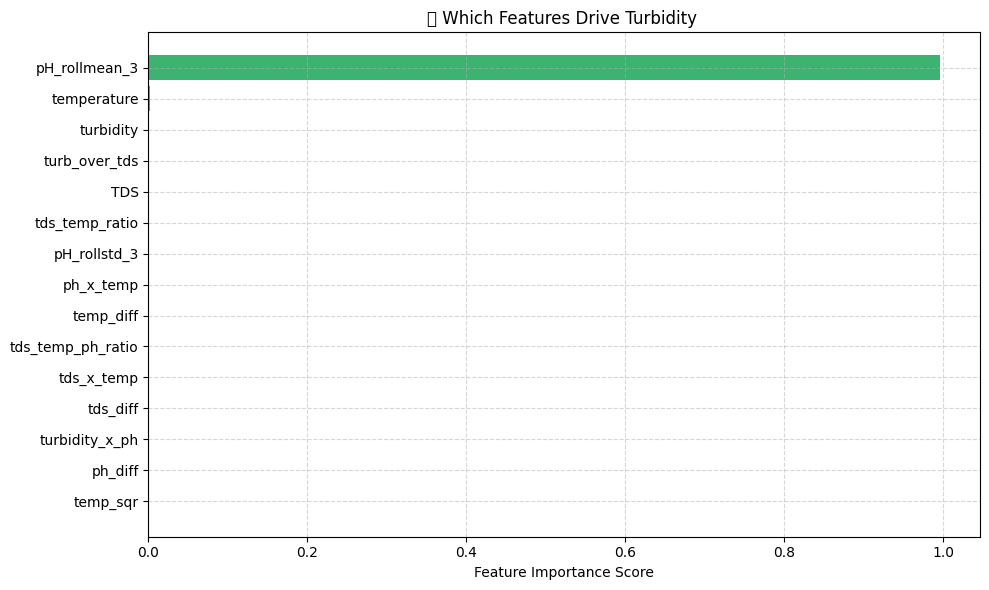

In [18]:
import matplotlib.pyplot as plt

# Get feature importances from trained model
importances = model_ph.feature_importances_
feature_names = X.columns

# Sort them
indices = np.argsort(importances)[::-1]
sorted_features = [feature_names[i] for i in indices]
sorted_importances = importances[indices]

# Plot
plt.figure(figsize=(10, 6))
plt.barh(sorted_features[::-1], sorted_importances[::-1], color='mediumseagreen')
plt.xlabel("Feature Importance Score")
plt.title("🌟 Which Features Drive  ")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()